In [1]:
import pandas as pd
import numpy as np
import xlrd
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import os
import random
from datetime import datetime, timedelta

from gpytorch.mlls import SumMarginalLogLikelihood
from itertools import repeat

import subprocess

## 데이터 경로 설정

In [2]:
save_date = "211213"

In [3]:
## python input data
path_input_1 = "../../../../01_data/국제/수집데이터_211213.xlsx" # 국제데이터 - 확진자, 사망자 보충 데이터
path_input_2 = "../../../../01_data/국내/covid19_Nov2.csv" # 중증자 보충 데이터
path_input_3 = "../../../../01_data/국내/질병청자료_2020.03.28-2021.12.08.xlsx" # 국내데이터 - 중증자  예정?(확진자, 사망자)


## r input data
path_r = "../../../../01_data/VAR/var_211213.csv" # r에 들어가는 input data

## output data
path_output_1 = "../../../../03_result/VAR/211213/var_211213_i.csv" # 확진자
path_output_2 = "../../../../03_result/VAR/211213/var_211213_s.csv" # 중증자 
path_output_3 = "../../../../03_result/VAR/211213/var_211213_d.csv" # 사망자

## image
save_path = "../../../../04_image/"+save_date+"/"+save_date+"/TS/VAR/" # 이미지 저장 폴더

In [4]:
path = pd.DataFrame({'input':[path_r], 'output_1':[path_output_1], 'output_2':[path_output_2], 'output_3':[path_output_3]})
path.to_csv("../../../../00_path/VAR/var_path.csv")
path

,input,output_1,output_2,output_3
0,../../../../01_data/VAR/var_211213.csv,../../../../03_result/VAR/211213/var_211213_i.csv,../../../../03_result/VAR/211213/var_211213_s.csv,../../../../03_result/VAR/211213/var_211213_d.csv


# 데이터 전처리


In [5]:
# 날짜 범위 설정
file_name_date = '20231231'
start_date = pd.Timestamp('2020-01-22')      # 학습 시작 날짜
end_date = pd.Timestamp('2021-12-08')        # 학습 끝 날짜(중증자 데이터 끝날짜)
pre_date = end_date + timedelta(days=1)       # 예측 시작 날짜
pre_end_date = pd.Timestamp('2023-12-31')    # 예측 끝 날짜

# 확진자, 중증자, 사망자의 예측시작을 동일하게 하기위해
train_date = pd.date_range(start_date,end_date)
predict_date = pd.date_range(pre_date,pre_end_date)

train_data = pd.DataFrame({'Date':pd.date_range(start_date,end_date)})
total_data = pd.DataFrame({'Date':pd.date_range(start_date,pre_end_date)})

total_data

,Date
0,2020-01-22
1,2020-01-23
2,2020-01-24
3,2020-01-25
4,2020-01-26
...,...
1435,2023-12-27
1436,2023-12-28
1437,2023-12-29
1438,2023-12-30


## 확진자, 사망자


In [6]:
data_case= pd.read_excel(path_input_1,engine = "openpyxl",sheet_name ='확진자,사망자수(US 제외)' )
data_case=data_case[data_case['Country'] =='South Korea']
#df_= df_1_2.drop(['Province1','Province2','Unnamed: 6'], axis=1, inplace=True)
data_case.drop(['Province1','Province2','Country'], axis=1, inplace=True)
data_case.rename(columns = {'tDate' : 'Date'}, inplace = True)
data_case['Date'] = pd.to_datetime(data_case['Date'], format="%Y-%m-%d")
data_case = data_case[data_case['Date'].isin(train_date)]
data_case


## total_data 에 merge
train_data = pd.merge(train_data, data_case, how='left',left_on='Date', right_on='Date')
train_data = train_data.fillna(0)
total_data = pd.merge(total_data, train_data, how='left',left_on='Date', right_on='Date')
total_data

,Date,Confirmed,Deaths
0,2020-01-22,0.0,0.0
1,2020-01-23,0.0,0.0
2,2020-01-24,1.0,0.0
3,2020-01-25,0.0,0.0
4,2020-01-26,1.0,0.0
...,...,...,...
1435,2023-12-27,NaN,NaN
1436,2023-12-28,NaN,NaN
1437,2023-12-29,NaN,NaN
1438,2023-12-30,NaN,NaN


### 확진자 데이터 수정(질병관리청 참고)

In [7]:
## 없는 데이터...
total_data.loc[total_data['Date']=='2021-09-25','Confirmed']= 3273
total_data.loc[total_data['Date']=='2021-10-03','Confirmed']= 2086

## 튀는 데이터...
total_data.loc[total_data['Date']=='2021-09-26','Confirmed']= 2771
total_data.loc[total_data['Date']=='2021-10-04','Confirmed']= 1673


##### 2021-12-17 자 수정
#### 확진자
total_data.loc[total_data['Date']=='2021-12-03','Confirmed']= 4944
total_data.loc[total_data['Date']=='2021-12-04','Confirmed']= 5352
total_data.loc[total_data['Date']=='2021-12-08','Confirmed']= 7175

#### 사망자
total_data.loc[total_data['Date']=='2021-12-03','Deaths']= 34
total_data.loc[total_data['Date']=='2021-12-04','Deaths']= 70
total_data.loc[total_data['Date']=='2021-12-08','Deaths']= 63

In [8]:
# total_data.loc[total_data['Date']=='2021-12-03','Confirmed']
total_data.loc[total_data['Date']=='2021-12-04','Confirmed']
# total_data.loc[total_data['Date']=='2021-12-08','Confirmed']

682    5352.0
Name: Confirmed, dtype: float64

## 중증자

### 2021-12-17 이전
이유엔 데이터의 시작이 2020-09-15부터임. <br>그 이전의 데이터는 <I>covid19_Nov2.csv</I>에서 가져옴.


### 2021-12-17
국제 데이터에 중증자 데이터가 2021-10-06이후로 업데이트 되지 않아, 국내 데이터-질병청자료 사용.<b>(IH 열)</b><br>
국내데이터 시작이 2020-07-20부터이고, 그 이전 데이터는 그 이전의 데이터는 <I>covid19_Nov2.csv</I>에서 가져옴.

In [9]:
data_sev_1= pd.read_excel(path_input_3,engine = "openpyxl",usecols = 'A,IH' )
data_sev_1 = data_sev_1.drop(index=[0, 1, 2, 3, 4], axis=0)
data_sev_1 = data_sev_1.dropna(axis = 0, how = 'any')
data_sev_1.rename(columns = {'Unnamed: 0' : 'Date','Unnamed: 241':'Severity'}, inplace = True)
data_sev_1.reset_index(drop=True, inplace=True)

sev_start_date = data_sev_1['Date'][0]                # 시작 날짜(이전의 데이터를 붙이기 위해 필요)
sev_end_date = data_sev_1['Date'][len(data_sev_1)-1]  # 끝 날짜 (이후의 데이터를 붙이기 위해 필요)

data_sev_1_2 = data_sev_1.fillna(0)
data_sev_1_2
data_sev_1

,Date,Severity
0,2020-07-20,19
1,2020-07-21,21
2,2020-07-22,21
3,2020-07-23,18
4,2020-07-24,16
...,...,...
502,2021-12-04,752
503,2021-12-05,744
504,2021-12-06,727
505,2021-12-07,774


In [10]:
data_sev_2 = pd.read_csv(path_input_2,usecols=[0,6])
data_sev_2['Date'] = pd.to_datetime(data_sev_2['Date'])
old_sev = data_sev_2.loc[data_sev_2['Date']<sev_start_date]
old_sev_1 = old_sev.fillna(0)
old_sev_1

# new_sev = data_sev_2.loc[(data_sev_2['Date']>sev_end_date) & (data_sev_2['Date']<pre_date)]
# new_sev.loc[(new_sev['Date']>'2021-10-06')&(new_sev['Date']<pre_date),'Severity']=376 ## 2021-09-09~2021-09-23까지 데이터가 없어서 2021-09-08데이터 쭉 넣음.
# new_sev

,Date,Severity
0,2020-01-20,0.0
1,2020-01-21,0.0
2,2020-01-22,0.0
3,2020-01-23,0.0
4,2020-01-24,0.0
...,...,...
177,2020-07-15,0.0
178,2020-07-16,0.0
179,2020-07-17,0.0
180,2020-07-18,0.0


In [11]:
# 이전 중증자 데이터 합치기
data_sev = pd.concat([old_sev_1,data_sev_1_2])
data_sev

,Date,Severity
0,2020-01-20,0.0
1,2020-01-21,0.0
2,2020-01-22,0.0
3,2020-01-23,0.0
4,2020-01-24,0.0
...,...,...
502,2021-12-04,752.0
503,2021-12-05,744.0
504,2021-12-06,727.0
505,2021-12-07,774.0


In [12]:
# total_data에 중증자 합치기
total_data = pd.merge(total_data, data_sev, how='left',left_on='Date', right_on='Date')
total_data

,Date,Confirmed,Deaths,Severity
0,2020-01-22,0.0,0.0,0.0
1,2020-01-23,0.0,0.0,0.0
2,2020-01-24,1.0,0.0,0.0
3,2020-01-25,0.0,0.0,0.0
4,2020-01-26,1.0,0.0,0.0
...,...,...,...,...
1435,2023-12-27,NaN,NaN,NaN
1436,2023-12-28,NaN,NaN,NaN
1437,2023-12-29,NaN,NaN,NaN
1438,2023-12-30,NaN,NaN,NaN


## [시나리오] 백신접종률
#### 2021-09-27 이전 시나리오
2021-09-09~2021-11-28 까지는 하루에 0.5 씩 증가하다가, 이후에 한달에 한번씩 1씩 증가 <br>
2022-06-01 부터 85로 고정됨.

#### 2021-09-27 시나리오
2021년 11월부터 사회적 거리두기 1단계, 백신접종율 70% 달성, 2022년 12월 80% 이상을 가정<br>
2021-09-18~2021-10-31 까지는 하루에 0.5 씩 증가 <br>
2021-11-01 부터는 하루에 0.1씩 증가하지만, 85에 달성하면 85유지


#### 2021-10-25 시나리오
2021-10-22까지 80달성(하루에 1씩증가?) <br>
2021-11-01까지 하루에 0.2씩 증가해서 82달성<br>
2022-01-01까지 한달에 한번씩 1 증가<br>
2023-11-01에 1증가(85)

In [13]:
# 일별 백신 접종률 ------- 시나리오

# 이유엔 데이터는 2021-09-15 까지 있음 (~2021-08-30까지는 M열, 그 이후는 N열(18세 이상))
date_18_start = pd.Timestamp('2021-08-31')

# 2021-08-31 이전 데이터 (M열)
data1 = pd.read_excel(path_input_1, engine = "openpyxl", sheet_name = "예방접종현황",usecols='A,M' )
data1.rename(columns = {'tDate' : 'Date','2_Rate':'Vaccine'}, inplace = True)
data1['Vaccine'] = data1['Vaccine'].fillna(0)
data1 = data1.loc[data1['Date']<date_18_start]
data1

# 2021-08-31 이후 데이터 (N열)
data2 = pd.read_excel(path_input_1, engine = "openpyxl", sheet_name = "예방접종현황",usecols='A,N' )
data2.rename(columns = {'tDate' : 'Date','2_18y_Rate':'Vaccine'}, inplace = True)
data2['Vaccine'] = data2['Vaccine'].fillna(0)
data2 = data2.loc[data2['Date']>=date_18_start]
data2



data_vac = pd.concat([data1,data2])
data_vac

,Date,Vaccine
0,2020-09-15,0.0
1,2020-09-16,0.0
2,2020-09-17,0.0
3,2020-09-18,0.0
4,2020-09-19,0.0
...,...,...
382,2021-10-02,60.2
383,2021-10-03,61.1
384,2021-10-04,61.2
385,2021-10-05,61.6


In [14]:
total_data = pd.merge(total_data, data_vac, on = 'Date', how = 'left')
total_data['Vaccine']=total_data['Vaccine'].fillna(0)
total_data

,Date,Confirmed,Deaths,Severity,Vaccine
0,2020-01-22,0.0,0.0,0.0,0.0
1,2020-01-23,0.0,0.0,0.0,0.0
2,2020-01-24,1.0,0.0,0.0,0.0
3,2020-01-25,0.0,0.0,0.0,0.0
4,2020-01-26,1.0,0.0,0.0,0.0
...,...,...,...,...,...
1435,2023-12-27,NaN,NaN,NaN,0.0
1436,2023-12-28,NaN,NaN,NaN,0.0
1437,2023-12-29,NaN,NaN,NaN,0.0
1438,2023-12-30,NaN,NaN,NaN,0.0


In [15]:
## 시나리오
## end_date부터 2021-10-22까지 80%달성
s_date_1 = pd.Timestamp('2021-10-22') 

## 2021-11-01까지 하루에 0.2씩 증가해서 82달성
s_date_2 = pd.Timestamp('2021-11-01')

## 2022-01-01까지 한달에 한번씩 1증가
s_date_3 = pd.Timestamp('2022-01-01')

## 2023-11-01에 1증가 --> 85달성
s_date_4 = pd.Timestamp('2023-11-01')

index_0 = int(total_data.loc[total_data['Date']==end_date].index.values)
index_1 = int(total_data.loc[total_data['Date']==s_date_1].index.values)
index_2 = int(total_data.loc[total_data['Date']==s_date_2].index.values)
index_3 = int(total_data.loc[total_data['Date']==s_date_3].index.values)
index_4 = int(total_data.loc[total_data['Date']==s_date_4].index.values)


## end_date부터 2021-10-22까지 80%달성
for i in range(index_0+1,index_1+1):
    total_data.loc[[i],'Vaccine']=float(total_data.loc[[i-1],'Vaccine'])+1.0 

## 2021-10-22 80달성
total_data.loc[total_data['Date']==s_date_1,'Vaccine']=80

## 2021-11-01까지 하루에 0.2씩 증가해서 82달성
for i in range(index_1+1,index_2+1):
    total_data.loc[[i],'Vaccine']=float(total_data.loc[[i-1],'Vaccine'])+0.2
    
## 2022-01-01까지 한달에 한번씩 1증가
cnt = 1
for i in range(index_2,index_3+1):
    if cnt % 31 == 0:
        total_data.loc[[i],'Vaccine'] = float(total_data.loc[[i-1],'Vaccine'])+1.0
    total_data.loc[[i+1],'Vaccine']=float(total_data.loc[[i],'Vaccine'])
    cnt += 1

### 2021 11월부터는 0.1씩 증가
for i in range(index_3,len(total_data)-1):
    if total_data['Date'][i] == s_date_4:
        total_data.loc[[i],'Vaccine'] = float(total_data.loc[[i-1],'Vaccine'])+1.0
    total_data.loc[[i+1],'Vaccine']=float(total_data.loc[[i],'Vaccine'])

total_data


,Date,Confirmed,Deaths,Severity,Vaccine
0,2020-01-22,0.0,0.0,0.0,0.0
1,2020-01-23,0.0,0.0,0.0,0.0
2,2020-01-24,1.0,0.0,0.0,0.0
3,2020-01-25,0.0,0.0,0.0,0.0
4,2020-01-26,1.0,0.0,0.0,0.0
...,...,...,...,...,...
1435,2023-12-27,NaN,NaN,NaN,85.0
1436,2023-12-28,NaN,NaN,NaN,85.0
1437,2023-12-29,NaN,NaN,NaN,85.0
1438,2023-12-30,NaN,NaN,NaN,85.0


## [시나리오] d_Vaccine
### 오늘 d_Vaccine = 오늘 Vaccine - 어제 Vaccine

In [16]:
total_data['d_Vaccine']=0.0
for i in range(1,len(total_data)):
    total_data.loc[[i],['d_Vaccine']] = float(total_data.loc[[i],['Vaccine']].values)-float(total_data.loc[[i-1],['Vaccine']].values)

total_data

,Date,Confirmed,Deaths,Severity,Vaccine,d_Vaccine
0,2020-01-22,0.0,0.0,0.0,0.0,0.0
1,2020-01-23,0.0,0.0,0.0,0.0,0.0
2,2020-01-24,1.0,0.0,0.0,0.0,0.0
3,2020-01-25,0.0,0.0,0.0,0.0,0.0
4,2020-01-26,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
1435,2023-12-27,NaN,NaN,NaN,85.0,0.0
1436,2023-12-28,NaN,NaN,NaN,85.0,0.0
1437,2023-12-29,NaN,NaN,NaN,85.0,0.0
1438,2023-12-30,NaN,NaN,NaN,85.0,0.0


## [시나리오] 변이바이러스 비율(알파, 델타)
#### 2021-09-27 이전 시나리오
* 알파 : train 마지막 날짜 이후는 마지막날짜 소수 4번째자리에서 반올림한 값으로 쭉감.
* 델타 : train 마지막 날짜 값은 0.992이지만, 그 이후부터 2021-10-01까지는 0.5, 그 이후로는 0.22로 넣음.(테스트)

#### 2021-10-25 시나리오
* 알파 : 2021-08-22까지 마지막 값 유지하다가 그 후 다 0
* 델타 : 마지막값 쭉 유지(covid19_Nov2.csv의 마지막값은 0.992337165 로 이유엔과 다름)

In [17]:
#기존데이터 전처리
# 값이 없는 날은 이전날짜의 값 넣음.
# start_date 이후로 proportion이 0 보다 큰 날 추출
data1 = pd.read_excel(path_input_1, engine = "openpyxl",sheet_name = '변이바이러스 비율',usecols=[0,1,2,5] )
data2 = data1['Country'] == 'South Korea'
data1 = data1[data2]
data1 = data1.loc[(data1['Date']> start_date) & data1['proportion']>0]
data1.reset_index(drop=True, inplace=True)
data1

,Country,Date,Variant,proportion
0,South Korea,2020-12-14,21C.Epsilon,0.012500
1,South Korea,2020-12-21,20I.Alpha.V1,0.035294
2,South Korea,2020-12-21,21C.Epsilon,0.035294
3,South Korea,2020-12-28,20I.Alpha.V1,0.048193
4,South Korea,2020-12-28,21C.Epsilon,0.036145
...,...,...,...,...
100,South Korea,2021-08-30,21A.Delta,0.993750
101,South Korea,2021-09-06,21A.Delta,0.992933
102,South Korea,2021-09-13,21A.Delta,0.996047
103,South Korea,2021-09-20,21A.Delta,0.997475


In [18]:
####### 알파
v_alpha = data1['Variant'] == '20I.Alpha.V1'
v_alpha = data1[v_alpha]

v_alpha.reset_index(drop=True, inplace=True)
v_alpha
d_v_alpha = v_alpha['Date'].to_list()
d_v_alpha


[Timestamp('2020-12-21 00:00:00'),
 Timestamp('2020-12-28 00:00:00'),
 Timestamp('2021-01-04 00:00:00'),
 Timestamp('2021-01-11 00:00:00'),
 Timestamp('2021-01-18 00:00:00'),
 Timestamp('2021-01-25 00:00:00'),
 Timestamp('2021-02-01 00:00:00'),
 Timestamp('2021-02-08 00:00:00'),
 Timestamp('2021-02-15 00:00:00'),
 Timestamp('2021-02-22 00:00:00'),
 Timestamp('2021-03-01 00:00:00'),
 Timestamp('2021-03-08 00:00:00'),
 Timestamp('2021-03-15 00:00:00'),
 Timestamp('2021-03-22 00:00:00'),
 Timestamp('2021-03-29 00:00:00'),
 Timestamp('2021-04-05 00:00:00'),
 Timestamp('2021-04-12 00:00:00'),
 Timestamp('2021-04-19 00:00:00'),
 Timestamp('2021-04-26 00:00:00'),
 Timestamp('2021-05-03 00:00:00'),
 Timestamp('2021-05-10 00:00:00'),
 Timestamp('2021-05-17 00:00:00'),
 Timestamp('2021-05-24 00:00:00'),
 Timestamp('2021-05-31 00:00:00'),
 Timestamp('2021-06-07 00:00:00'),
 Timestamp('2021-06-14 00:00:00'),
 Timestamp('2021-06-21 00:00:00'),
 Timestamp('2021-06-28 00:00:00'),
 Timestamp('2021-07-

In [19]:
p_v_alpha = v_alpha['proportion'].to_list()
p_v_alpha[0]
total_data.loc[total_data['Date']=='2021-08-18']

,Date,Confirmed,Deaths,Severity,Vaccine,d_Vaccine
574,2021-08-18,1803.0,5.0,366.0,20.4,0.9


In [20]:
# 예측 시나리오 데이터 전처리
# 2021-08-22까지 마지막 값 유지하다가 그 후 다 0

scenario_date = pd.Timestamp('2021-08-23')
total_data['VM_alpha']=0

for i in range(len(v_alpha)):
    if i <= len(v_alpha)-2:
        total_data.loc[(total_data['Date']>= d_v_alpha[i])&(total_data['Date']<d_v_alpha[i+1]),'VM_alpha'] = p_v_alpha[i]
    if i == len(v_alpha)-1:
        total_data.loc[(total_data['Date']>= d_v_alpha[i])&(total_data['Date']<scenario_date),'VM_alpha']=p_v_alpha[i]
total_data.loc[total_data['Date']>= scenario_date,'VM_alpha'] = round(p_v_alpha[-1],2)
total_data

,Date,Confirmed,Deaths,Severity,Vaccine,d_Vaccine,VM_alpha
0,2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-24,1.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-01-26,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
1435,2023-12-27,NaN,NaN,NaN,85.0,0.0,0.0
1436,2023-12-28,NaN,NaN,NaN,85.0,0.0,0.0
1437,2023-12-29,NaN,NaN,NaN,85.0,0.0,0.0
1438,2023-12-30,NaN,NaN,NaN,85.0,0.0,0.0


In [21]:
####### 델타
v_delta = data1['Variant'] == '21A.Delta'
v_delta = data1[v_delta]
v_delta.reset_index(drop=True, inplace=True)
v_delta

d_v_delta = v_delta['Date'].to_list()
d_v_delta[0]
p_v_delta = v_delta['proportion'].to_list()
p_v_delta[0]

v_delta

,Country,Date,Variant,proportion
0,South Korea,2021-04-19,21A.Delta,0.004464
1,South Korea,2021-04-26,21A.Delta,0.012500
2,South Korea,2021-05-03,21A.Delta,0.023923
3,South Korea,2021-05-10,21A.Delta,0.046980
4,South Korea,2021-05-17,21A.Delta,0.056075
5,South Korea,2021-05-24,21A.Delta,0.046729
6,South Korea,2021-05-31,21A.Delta,0.045752
7,South Korea,2021-06-07,21A.Delta,0.053922
8,South Korea,2021-06-14,21A.Delta,0.116592
9,South Korea,2021-06-21,21A.Delta,0.229249


In [22]:
# 예측 시나리오 데이터 전처리
total_data['VM_delta']=0

for i in range(len(v_delta)):
    if i <= len(v_delta)-2:
        total_data.loc[(total_data['Date']>= d_v_delta[i])&(total_data['Date']<d_v_delta[i+1]),'VM_delta'] = p_v_delta[i]
    if i == len(v_delta)-1:
        total_data.loc[(total_data['Date']>= d_v_delta[i])&(total_data['Date']<=pre_end_date),'VM_delta']=p_v_delta[i]
# total_data.loc[(total_data['Date']>= pre_date)&(total_data['Date']<scenario_date),'VM_delta'] = 0.5
# total_data.loc[total_data['Date']>= scenario_date,'VM_delta'] = 0.22

# total_data.loc[(total_data['Date']>= pre_date)&(total_data['Date']<'2021-10-02'),'VM_delta'] = 0.5
# total_data.loc[total_data['Date']>= pre_date,'VM_delta'] = round(p_v_delta[-1],2)
total_data

,Date,Confirmed,Deaths,Severity,Vaccine,d_Vaccine,VM_alpha,VM_delta
0,2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,2020-01-24,1.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,2020-01-26,1.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...
1435,2023-12-27,NaN,NaN,NaN,85.0,0.0,0.0,0.996599
1436,2023-12-28,NaN,NaN,NaN,85.0,0.0,0.0,0.996599
1437,2023-12-29,NaN,NaN,NaN,85.0,0.0,0.0,0.996599
1438,2023-12-30,NaN,NaN,NaN,85.0,0.0,0.0,0.996599


## [시나리오] 사회적거리두기 Score(Oxford Index)
#### 2021-09-27 시나리오
2021-11-01부터 사회적거리두기 1단계 --> 25


#### 2021-10-25 시나리오
이유엔 데이터가 끝나면 뒷날짜 다 0

In [23]:
data1 = pd.read_excel(path_input_1,engine = "openpyxl",sheet_name = '사회적거리두기_Score',usecols='A,B,M' )
data1=data1[data1['Country'] =='South Korea']

data1.tail(50)
data1 = data1.drop(data1.tail(3).index, axis=0)  ## 마지막 3행은 0이라서 신뢰할 수 없어 삭제
data1= data1.drop(['Country'], axis=1)
data1.rename(columns = {'tDate' : 'Date','Stringency_Index':'Ox'}, inplace = True)
data1

,Date,Ox
154688,2020-01-01,0.000000
154689,2020-01-02,0.000000
154690,2020-01-03,0.000000
154691,2020-01-04,0.000000
154692,2020-01-05,0.000000
...,...,...
155371,2021-12-05,32.027777
155372,2021-12-06,33.416666
155373,2021-12-07,0.000000
155374,2021-12-08,0.000000


In [24]:
data1 = data1.reset_index(drop=True)
last_data = data1['Ox'][len(data1)-1]
ox_last_date = data1['Date'][len(data1)-1]
last_data

0.0

In [25]:
total_data = pd.merge(total_data, data1, how='left',left_on='Date', right_on='Date')
total_data

,Date,Confirmed,Deaths,Severity,Vaccine,d_Vaccine,VM_alpha,VM_delta,Ox
0,2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,2020-01-24,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,2020-01-26,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...
1435,2023-12-27,NaN,NaN,NaN,85.0,0.0,0.0,0.996599,NaN
1436,2023-12-28,NaN,NaN,NaN,85.0,0.0,0.0,0.996599,NaN
1437,2023-12-29,NaN,NaN,NaN,85.0,0.0,0.0,0.996599,NaN
1438,2023-12-30,NaN,NaN,NaN,85.0,0.0,0.0,0.996599,NaN


In [26]:
# ## 1단계 시작날짜 - 시나리오
# grade_1_start = pd.Timestamp('2021-11-01')

# ## 1단계 시나리오 시작 전까진 마지막 train날짜 이어가기
# total_data.loc[(total_data['Date']< grade_1_start) & (total_data['Date']>ox_last_date),'Ox'] = last_data

# ## 1단계 시나리오 시작날부터 1단계로 설정
# total_data.loc[total_data['Date']>= grade_1_start,'Ox'] = 25
# total_data

## 이유엔 데이터 끝나면 뒷날짜 다 0
total_data['Ox'] = total_data['Ox'].fillna(0)
total_data

,Date,Confirmed,Deaths,Severity,Vaccine,d_Vaccine,VM_alpha,VM_delta,Ox
0,2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,2020-01-24,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,2020-01-26,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...
1435,2023-12-27,NaN,NaN,NaN,85.0,0.0,0.0,0.996599,0.0
1436,2023-12-28,NaN,NaN,NaN,85.0,0.0,0.0,0.996599,0.0
1437,2023-12-29,NaN,NaN,NaN,85.0,0.0,0.0,0.996599,0.0
1438,2023-12-30,NaN,NaN,NaN,85.0,0.0,0.0,0.996599,0.0


# 전처리 완료 --> Input CSV 저장

In [27]:
#R코드에 넣을 input데이터 저장
total_input_data = total_data.set_index("Date")
total_input_data.to_csv(path_r)

# VAR R 코드 실행

### Input Columns : Confirmed, Severity, Deaths, Vaccine, d_Vaccine, VM_alpha, VM_delta, Ox

In [28]:
#####VAR
command = '/home/sysadm/anaconda3/envs/gil/bin/Rscript'
arg = '--vanilla'
path2script = '../../../../02_code/VAR/R/211105/r_var_211105.R'

retcode = subprocess.call([command, arg, path2script])

# VAR 그래프 그리기

In [29]:
#예측값 데이터 - 확진자
x_confirmed = pd.read_csv(path_output_1)
x_confirmed.rename(columns = {'Unnamed: 0' : 'Date'}, inplace = True)
x_confirmed['Date'] = pd.to_datetime(x_confirmed['Date'],format ="%Y-%m-%d" )

x_confirmed

,Date,PointForecast,Lo95,Hi95,NA
0,2021-12-09,5.571024e+03,5.535306e+03,5.606743e+03,3.571884e+01
1,2021-12-10,5.878454e+03,5.806057e+03,5.950852e+03,7.239716e+01
2,2021-12-11,6.169828e+03,6.058018e+03,6.281638e+03,1.118104e+02
3,2021-12-12,6.479339e+03,6.324306e+03,6.634373e+03,1.550337e+02
4,2021-12-13,6.834242e+03,6.632922e+03,7.035562e+03,2.013196e+02
...,...,...,...,...,...
748,2023-12-27,1.404172e+19,1.293357e+19,1.514987e+19,1.108149e+18
749,2023-12-28,1.472643e+19,1.356424e+19,1.588861e+19,1.162186e+18
750,2023-12-29,1.544453e+19,1.422567e+19,1.666339e+19,1.218857e+18
751,2023-12-30,1.619765e+19,1.491935e+19,1.747594e+19,1.278292e+18


In [30]:
#예측값 데이터 - 중증 환자
x_severity = pd.read_csv(path_output_2)
x_severity.rename(columns = {'Unnamed: 0' : 'Date'}, inplace = True)
x_severity['Date'] = pd.to_datetime(x_severity['Date'],format ="%Y-%m-%d" )

x_severity

,Date,PointForecast,Lo95,Hi95,NA
0,2021-12-09,7.782145e+02,7.760154e+02,7.804136e+02,2.199092e+00
1,2021-12-10,8.010163e+02,7.962133e+02,8.058193e+02,4.802974e+00
2,2021-12-11,8.265110e+02,8.187836e+02,8.342385e+02,7.727448e+00
3,2021-12-12,8.573885e+02,8.463077e+02,8.684693e+02,1.108082e+01
4,2021-12-13,8.917822e+02,8.768015e+02,9.067629e+02,1.498071e+01
...,...,...,...,...,...
748,2023-12-27,2.130762e+18,1.962605e+18,2.298918e+18,1.681562e+17
749,2023-12-28,2.234663e+18,2.058307e+18,2.411019e+18,1.763560e+17
750,2023-12-29,2.343632e+18,2.158676e+18,2.528587e+18,1.849556e+17
751,2023-12-30,2.457913e+18,2.263939e+18,2.651888e+18,1.939745e+17


In [31]:
#예측값 데이터 - 사망자
x_deaths = pd.read_csv(path_output_3)
x_deaths.rename(columns = {'Unnamed: 0' : 'Date'}, inplace = True)
x_deaths['Date'] = pd.to_datetime(x_deaths['Date'],format ="%Y-%m-%d" )

x_deaths

,Date,PointForecast,Lo95,Hi95,NA
0,2021-12-09,5.364864e+01,5.265389e+01,5.464340e+01,9.947521e-01
1,2021-12-10,5.767533e+01,5.623271e+01,5.911794e+01,1.442611e+00
2,2021-12-11,6.029190e+01,5.846617e+01,6.211763e+01,1.825732e+00
3,2021-12-12,6.518709e+01,6.299763e+01,6.737655e+01,2.189462e+00
4,2021-12-13,6.897066e+01,6.639897e+01,7.154234e+01,2.571686e+00
...,...,...,...,...,...
748,2023-12-27,1.835524e+17,1.690667e+17,1.980380e+17,1.448565e+16
749,2023-12-28,1.925029e+17,1.773109e+17,2.076949e+17,1.519201e+16
750,2023-12-29,2.018899e+17,1.859570e+17,2.178227e+17,1.593282e+16
751,2023-12-30,2.117346e+17,1.950248e+17,2.284443e+17,1.670974e+16


In [32]:
def _Plot(x):
    if x == 'Incidence':
        column = 'Confirmed'
        predict = x_confirmed
        folder = 'I/'
#         y_lim = [-300,150000]
    elif x == 'Severity':
        column = 'Severity'
        predict = x_severity
        folder = 'S/'
#         y_lim = [-100,15000]
    else:
        column = 'Deaths'
        predict = x_deaths
        folder = 'D/'
#         y_lim = [-10,15000]
        
    ################스타일#######################################
    fig = plt.figure(figsize=(40,15)) ## 캔버스 생성
    fig.patch.set_facecolor('#050636') 
    plt.rcParams['text.color'] = 'w'
    plt.rcParams['xtick.color'] = 'w'
    plt.rcParams['ytick.color'] = 'w'
    plt.rcParams['axes.spines.left'] = True
    plt.rcParams['axes.facecolor']='#050636'
    plt.grid(color='w', linestyle='-', linewidth=3,alpha = 0.5)
    plt.gca().spines['bottom'].set_visible(True) #위 테두리
    plt.gca().spines['left'].set_visible(True) #왼쪽 테두리
#     plt.ylim(y_lim)
    ##############################################
    
    
    ################ Ground Truth #######################################
    plt.plot(total_data['Date'], total_data[column],color = '#2dcafd',  linewidth = 6)
    
    
    ################ Prediction #######################################
    plt.plot(predict_date,predict['PointForecast'], color ='#f13eab', linewidth = 8)
    plt.fill_between(predict['Date'], predict['Lo95'],predict['Hi95'], color = '#f13eab',alpha=0.2)
    
    plt.legend(['Ground-Truth', 'Prediction','Confidence'],fontsize=30,loc = 'upper left', edgecolor = 'w') #왜 이게 적용안되지?
    plt.axvline(x = pre_date,linestyle = ':',color='w',linewidth=8, alpha = 0.7)
    plt.xticks([start_date,'2020-06-01','2020-11-01','2021-05-01',pre_date,'2022-04-01','2022-09-01','2023-03-01','2023-08-01',pre_end_date],[str(start_date)[:10],'2020-06','2020-11','2021-05',str(pre_date)[:10],'2022-04','2022-09','2023-03','2023-08',str(pre_end_date)[:10]],fontsize=30)
    plt.yticks(fontsize = 30)
    plt.tight_layout()
    plt.savefig(save_path+folder+file_name_date+"_None_None_None",dpi=300)
    plt.show()

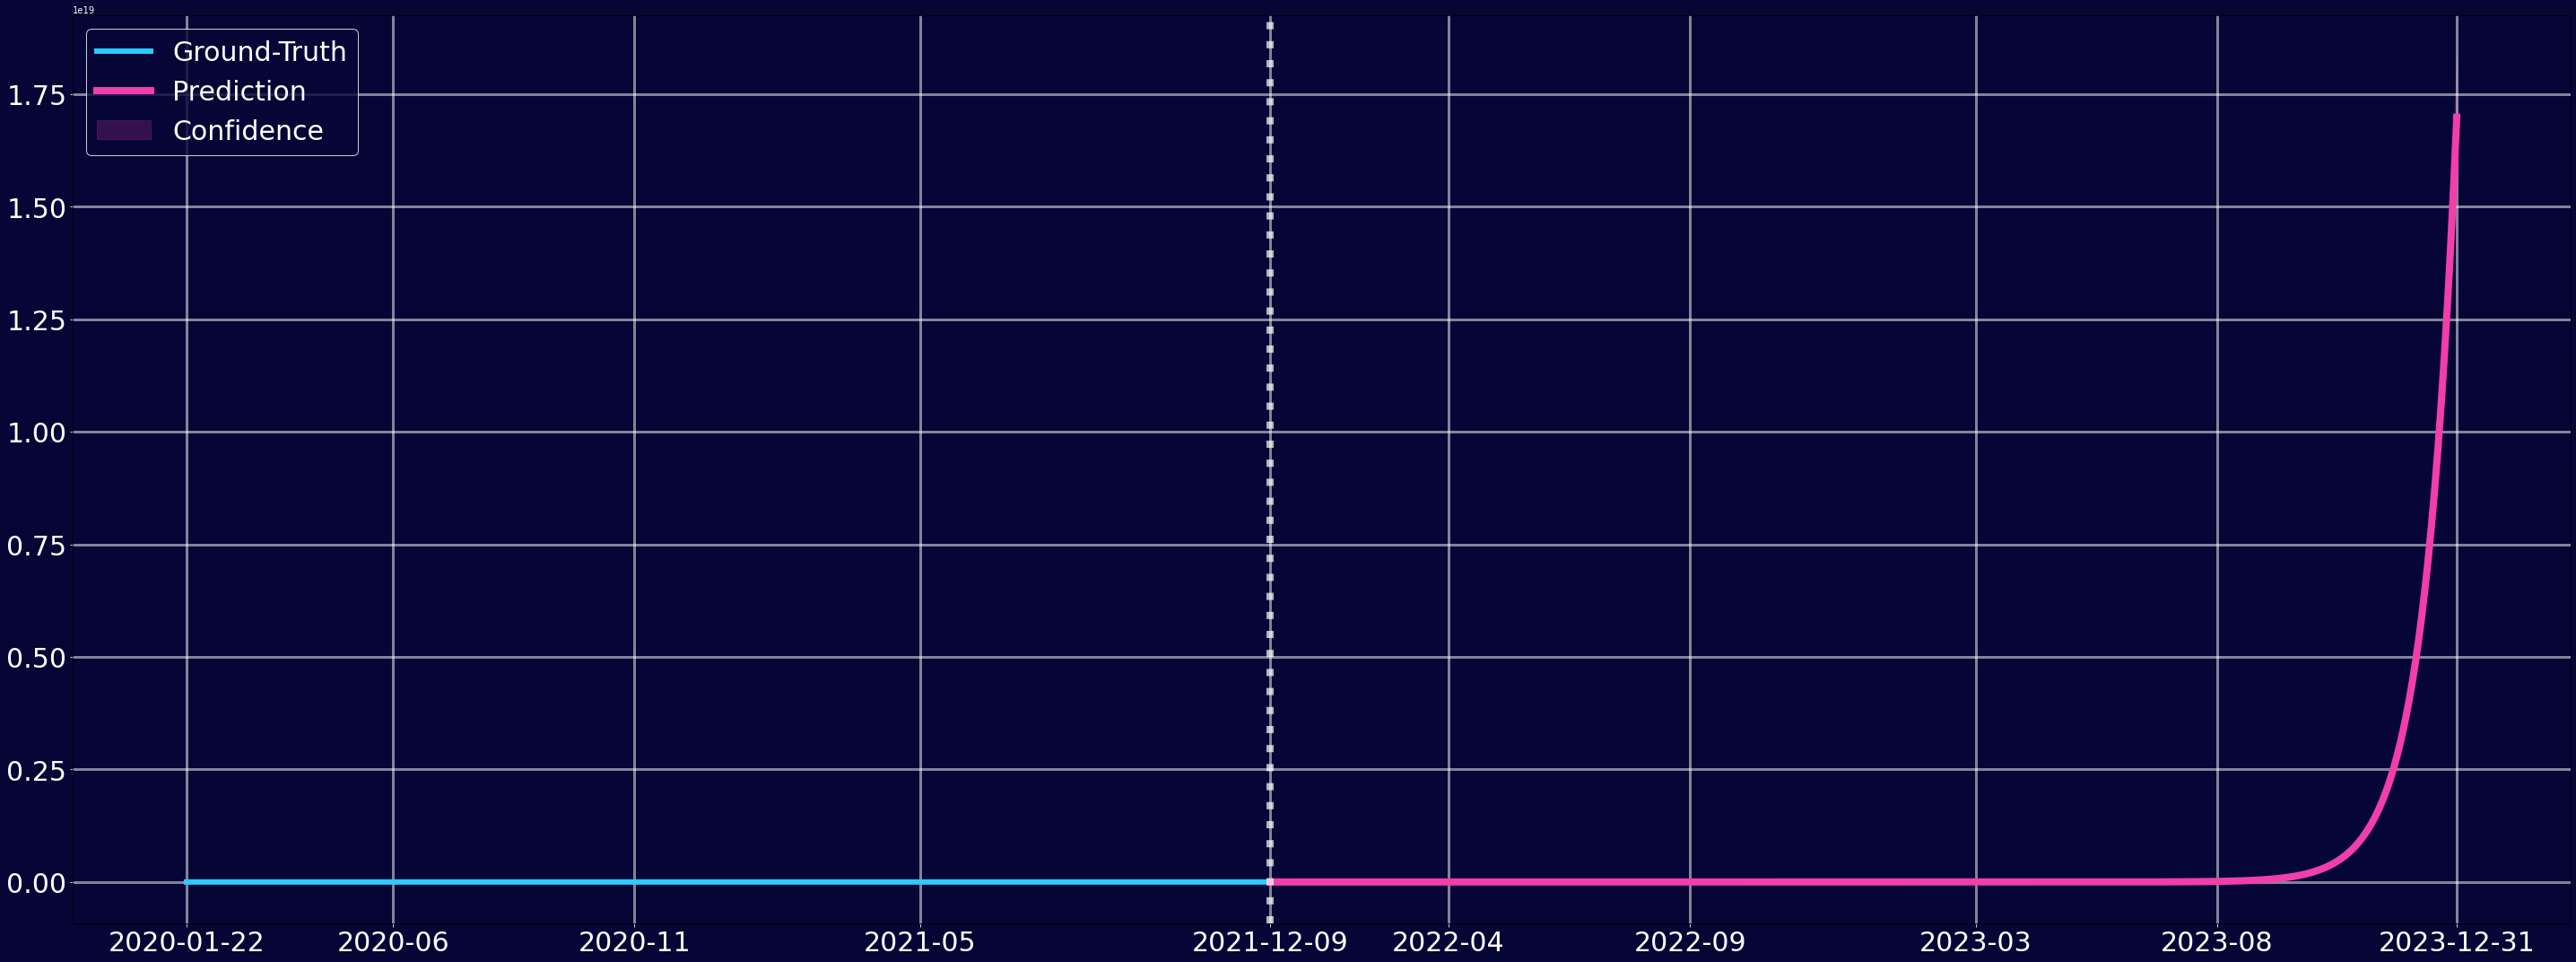

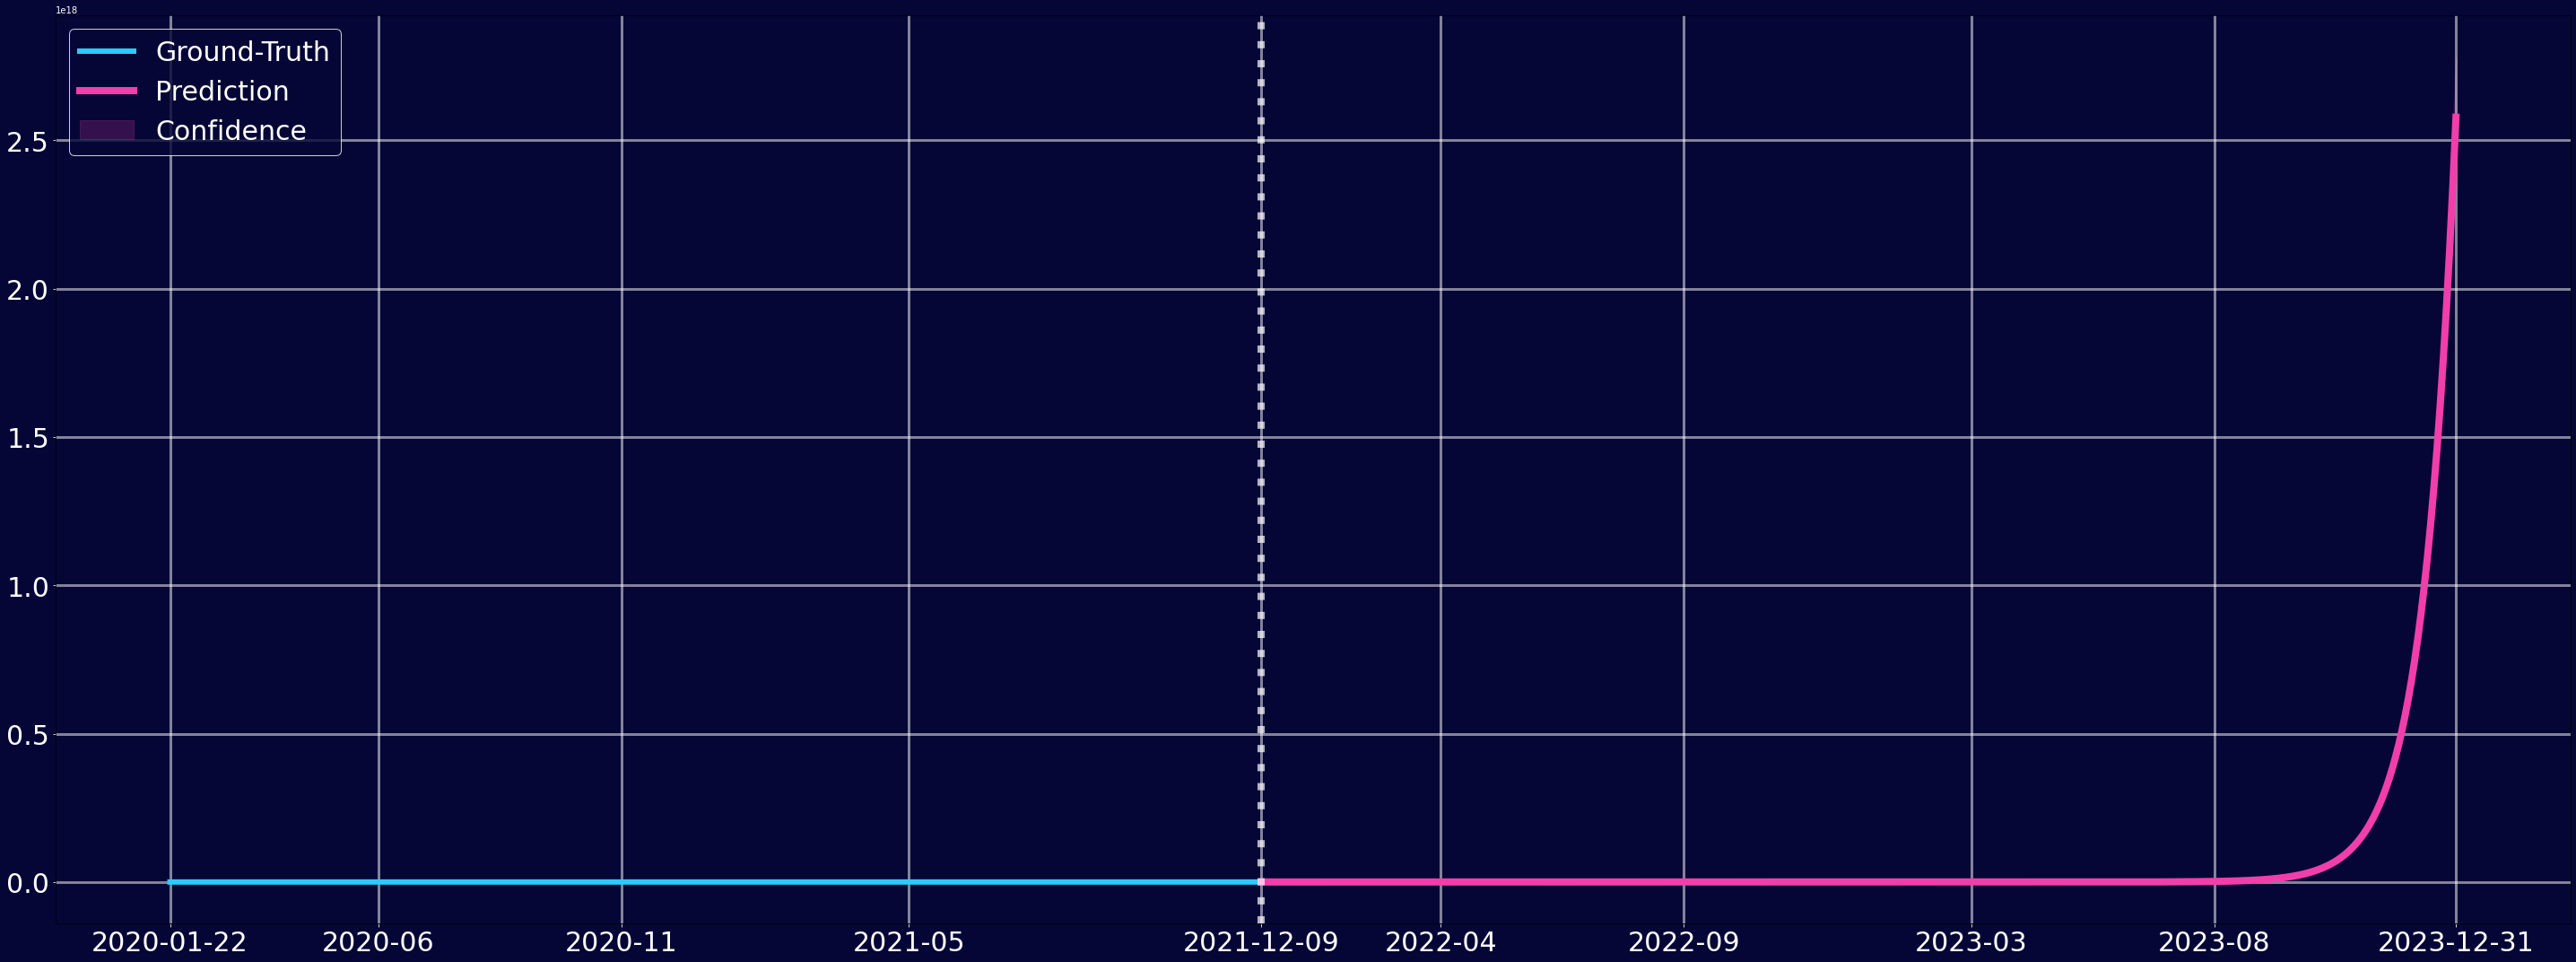

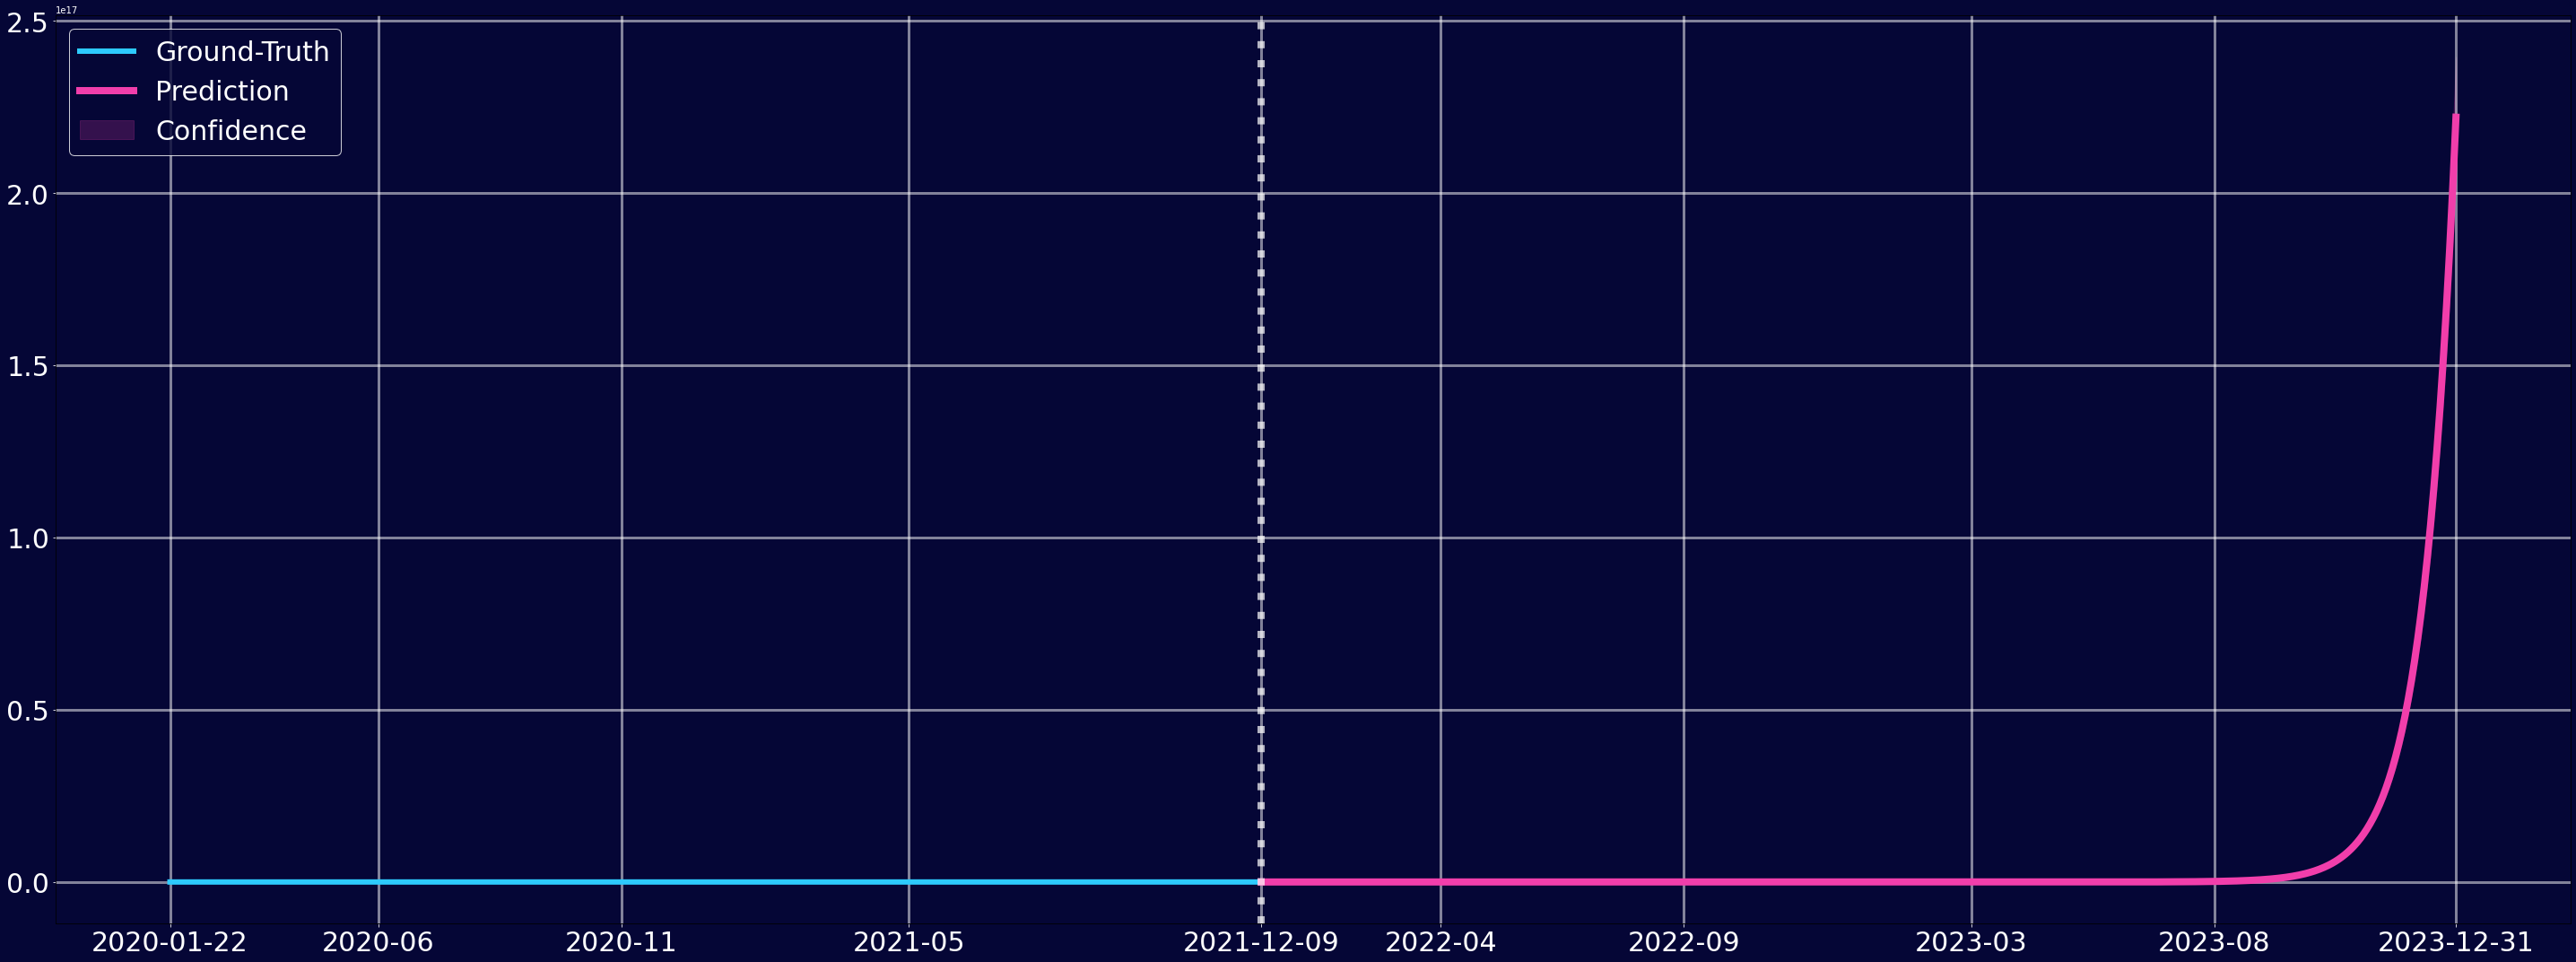

In [33]:
_Plot('Incidence')
_Plot('Severity')
_Plot('Deaths')
